# XGBoost to predict discharge disability: Mimic Emberson meta-analysis
Relationship between onset to thrombolysis time, and its SHAP value for a better outcome.


### Plain English summary

Use the set of six binary models trained in notebook 080 to predict whether the patient is below an mRS threshold value, using 7 features: "prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", "precise_onset_known".

For the analysis in this notebook, take just the patients from the test set that receive thrombolysis. Create a dataframe that has this subset of patients repeated 6 times (one for each mRS threshold). Use the set of 6 binary models to populate the dataframe with the SHAP values for onset to thrombolysis time.

Fit a linear regression of SHAP value for onset to treatment time vs feature value onset to treatment time. Repeat this for 1) the whole dataset, so for the six repetitions of the patients in the test set that got thrombolysis, having a SHAP value for each of the mRS thresholds used to create a binary target value (<=0, <=1, <=2, <=3, <=4, <=5, and 2) each mRS threshold separately.

Hypothesis, if the data represents the results of the Emberson meta analysis, at t=0 should see SHAP value 0.7. Should cross no effect line (SHAP value 0) at 6.3hours (378mins). Applied cutoff at 4.5hours as that point was statistically significant.

### Model and data

Model: Set of 6 binary XGBoost classification models, predicting whether patient is at least as well as each mRS level at discharge. [trained in notebook 080]\
Target feature: At least as well as each mRS level (binary feature)\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)\
Kfold split: First kfold split
[SHAP values from notebook 080, and also SHAP values calculated in this notebook for setting each patient to no treatment]

### Aims


### Observations




#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

## Import libraries

In [30]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import time
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


Report the time duration to run notebook

In [31]:
start_time = time.time()

Use just the first k-fold split, and define the target feature

In [32]:
k = 0
# Values to use as the threshold <= n in order to divide the target feature
list_binary_thresholds = [0, 1, 2, 3, 4, 5]

n_binary_models = len(list_binary_thresholds)

Select the features for the model

In [33]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features = len(selected_features)

target_feature = 'discharge_disability'
selected_features.append(target_feature)

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [34]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_{n_features}_features_1_kfold_binary'
    notebook: str = '100_'

paths = Paths()

Create output folders if needed

In [35]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Import the first kfold split

In [36]:
# Read in training set, restrict to chosen features, & store
filename = os.path.join(paths.data_read_path, '03_train_0.csv')
train = pd.read_csv(filename)
train = train[selected_features]

filename = os.path.join(paths.data_read_path, '03_test_0.csv')
test = pd.read_csv(filename)
test = test[selected_features]

Store the output classes

In [37]:
class_names = train['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [38]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [39]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [40]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        train = convert_feature_to_one_hot(train, feature, prefix)
        test = convert_feature_to_one_hot(test, feature, prefix)

Feature names with one hot encoding

In [41]:
features_ohe = list(train)
features_ohe.remove("discharge_disability")
n_features_ohe = len(features_ohe)

print(f"There are {n_features} original features (before one-hot encoding)")
print(f"There are {n_features_ohe} features (after one-hot encoding)")

There are 7 original features (before one-hot encoding)
There are 124 features (after one-hot encoding)


Create function to return X and y data for train and test sets

In [42]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    Args:
        train [dataframe]: dataframe containing training instances 
        test [dataframe]: dataframe containing test instances
        target [string]: column name of the targert feature (the column to separate 
                        from the two dataframes)

    Returns:
        X_train [dataframe]: dataframe containing input features for the 
                            training instances 
        X_test [dataframe]: dataframe containing target feature for the training 
                            instances 
        y_train [dataframe]: dataframe containing input features for the 
                             training instances 
        y_test [dataframe]: dataframe containing target features for the 
                            training instances 
    """       

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Keep original y_test and y_train, then overwrite them for each binary model (using a different threshold)

In [43]:
(X_train, X_test, y_train_orig, y_test_orig) = get_x_y_data(train, test,
                                                         'discharge_disability')

## Load XGBoost model

From notebok 080, load the set of 6 binary models (each with the 7 input features), each one predicting the disability discharge using a different mRS threshold (<=0, <=1, <=2, <=3, <=4, <=5)

Same X data, set different y data depending on the threshold.

Use just the first kfold threshold.

In [44]:
def convert_feature_to_binary(series, binary_threshold):
    result = (series <= binary_threshold) * 1
    return(result)

In [45]:
def load_xgboost(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Notify to run notebook 080 first
        print ("Run notebook 080 first, that trains the set of binary models")

    return(model)

In [46]:
def load_shap_extended(filename):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        model [xgboost classification model object]: xgboost object
        k [integer]: kfold number
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [dictionary]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """    
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load SHAP values extended
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Notify to run notebook 080 first
        print ("Run notebook 080 first, that trains the set of binary models")
            
    return(shap_values_extended)

In [47]:
roc_auc_ovr_threshold = []
accuracy_threshold = []
error_within_one_threshold = []
feature_importance_threshold = []
y_probs_threshold = []
y_pred_threshold = []
model_threshold = []
shap_values_test_extended_threshold = []
list_shap_values_extended = []

# Loop through mRS thresholds
# Include the new binary feature we calculate (replaces the multiclass feature)
for binary_threshold in list_binary_thresholds:
    binary_target_feature = f'binary_{binary_threshold}'
    y_train = convert_feature_to_binary(y_train_orig, binary_threshold)
    y_test = convert_feature_to_binary(y_test_orig, binary_threshold)

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                            (paths.notebook + paths.model_text + '_' +
                             str(binary_threshold) + '.p'))

    model = load_xgboost(filename)

    model_threshold.append(model)

    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_threshold.append(y_probs)#[:,1])

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_threshold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs[:,1], labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_threshold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_threshold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_threshold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_threshold.append(feature_importance)

    # Load SHAP for test dataset (from notebook 080)
    shap_extended_filename = os.path.join(paths.data_save_path, 
                                      (paths.notebook + paths.model_text +
                                       '_' + str(binary_threshold) + 
                                       '_shap_values_test_extended.p'))

    (shap_values_test_extended) = load_shap_extended(shap_extended_filename)
    
    # Append shap values extended to list
    list_shap_values_extended.append(shap_values_test_extended)

Create the dataframe of values

Take patients from test set that receive thrombolysis. Create a dataframe that has these patients repeated 6 times (one for each mRS threshold), and store their SHAP value and feature value for the feature "onset_to_thromboylsis_time".

Fit a linear regression to the SHAP vs feature value.

In [48]:
# Find the column index for the feature "onset_to_thrombolysis_time
ivt_loc = X_test.columns.tolist().index("onset_to_thrombolysis_time")

In [49]:
def create_df(X_data, list_shap_values_extended, mask, ivt_loc):
    """ 
    
    """
    # initiate a Dataframe with the required columns 
    columns=["patient_id", "mRS_threshold", "shap_ivt", 
             "onset_to_thrombolysis_time"]
    df = pd.DataFrame(columns=columns)

    # Go through each mRS threshold and create a temporary dataframe, then 
    # append it (add rows) to the main dataframe.
    for t in range(6):
        # Initiate dataframe        
        df_temp = pd.DataFrame(data=mask.index[mask], 
                            columns=["patient_id"])
        
        # Store the mRS threshold
        df_temp[f"mRS_threshold"] = t

        # Extract SHAP values for this threshold
        shap_values = list_shap_values_extended[t].values

        # Store the SHAP values for this threshold, for feature onset_to_thrombolysis_time
        df_temp["shap_ivt"] = (shap_values[mask, ivt_loc])
        
        # Store the feature values for feature onset_to_thrombolysis_time
        df_temp["onset_to_thrombolysis_time"] = (
                    X_data["onset_to_thrombolysis_time"][mask].values)

        # Append rows to the main dataframe
        df = df.append(df_temp)

    return(df)

In [50]:
# mask the patients in test set that recieve IVT
mask_get_ivt = X_test["onset_to_thrombolysis_time"] > -100

# create dataframe of the SHAP values for feature onset_to_thrombolysis for 
# patients that receive IVT (for each threshold model)
df_test_ivt_shap = create_df(X_test, list_shap_values_extended, 
                             mask_get_ivt, ivt_loc)

In [51]:
df_test_ivt_shap

,patient_id,mRS_threshold,shap_ivt,onset_to_thrombolysis_time
0,6,0,0.575995,90.0
1,7,0,0.453751,183.0
2,12,0,0.557330,187.0
3,15,0,0.066782,232.0
4,16,0,0.353205,165.0
...,...,...,...,...
6892,33652,5,0.539300,132.0
6893,33656,5,-0.221347,118.0
6894,33657,5,-0.002620,180.0
6895,33666,5,0.169626,124.0


### Fit Linear Regression model
Fit SHAP for onset to treatment time vs feature value onset to treatment time

Text(0, -1.9, 'At time = 0, SHAP = 0.655')

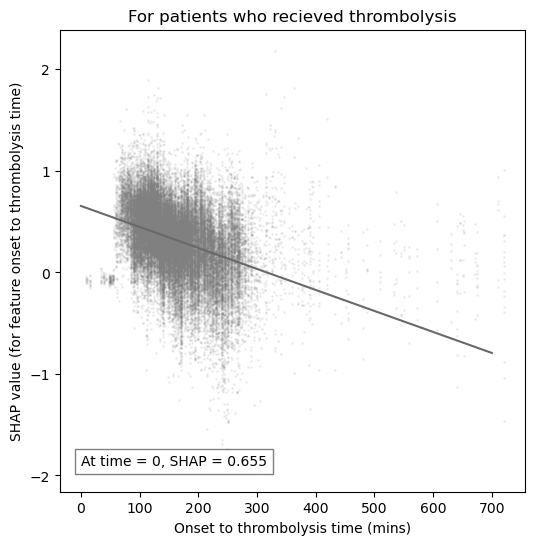

In [52]:
# Generate data
x = df_test_ivt_shap["onset_to_thrombolysis_time"]
y = df_test_ivt_shap["shap_ivt"]

# Initialize layout
fig, ax = plt.subplots(figsize = (6, 6))

# Add scatterplot
ax.scatter(x, y, s=1, color='grey', alpha=0.1)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 700 
xseq = np.linspace(-0, 700, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="dimgray", lw=1.5);

ax.set_xlabel("Onset to thrombolysis time (mins)")
ax.set_ylabel("SHAP value (for feature onset to thrombolysis time)")
ax.set_title("For patients who recieved thrombolysis")

ax.text(0, -1.9, f"At time = 0, SHAP = {round(a,3)}", 
        bbox=dict(facecolor='white', alpha=0.5))

In introduction, stated that "if the data represents the results of the Emberson meta analysis, at t=0 should see SHAP value 0.7. Should cross no effect line (SHAP value 0) at 6.3hours (378mins)."

Here are those numbers:

In [53]:
print(f"At t=0, SHAP value {round(a,3)} (log odds)")
print(f"No effect line (SHAP value 0) at {round(-a/b)} minutes")

At t=0, SHAP value 0.655 (log odds)
No effect line (SHAP value 0) at 316 minutes


Want to fit to the improvement due to thrombolysis.

To do this, calculate the difference in the SHAP value for feature Onset to thrombolysis time for patients when they have, and don't have, thrombolysis. 

Do this by only using the patients in the training set that have thrombolysis. Set those patients that have thrombolysis as not having it (with all other features the same), and getting new SHAP values for the features. We then calculate the improvement due to IVT by subtracting the SHAP when not have IVT, from the SHAP when they did have IVT.

For each patient calculate the improvement due to thrombolysis by subtracting their SHAP value as if not have thrtombolysis (wrt threshold).

Recalculate the linear regression (per threshold), fitting to the improvement due to IVT.


For each thrombolysed patient we calculate an estimated thrombolysis treatment effect: thrombolysis SHAP with treatment - thrombolysis SHAP if no treatment was given 

Do this by changing just the feature value for onset_to_thrombolysis_time to -100 (to represent no treatment recieved), and re-calculating the SHAP values.

[in notebook 110, we use this data to build a XGBoost regression model to predict thrombolysis treatment effect. Then add SHAP to that, and we see what patient features improve benefit from thrombolysis, and which reduce.
We might also want to just look at characteristics of patients with a negative treatment effect, vs those with a positive treatment effect.]

In [54]:
def calculate_shap_extended(filename, model, X_train, X_test):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        filename [string]: name of file containing SHAP extended data
        model [xgboost classification model object]: xgboost object
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [object]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values
        
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)
            
        # Save shap values extended using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
    return(shap_values_extended)

In [55]:
# Take deep copy of X_test, setting all patients as not having treatment
X_test_not_get_ivt = X_test.copy(deep=True)
X_test_not_get_ivt["onset_to_thrombolysis_time"] = -100

# Initialise empty list
list_shap_values_extended_no_ivt = []

# Loop through thresholds.
for t in range(6):  

    # Get model
    model = model_threshold[t]

    # set up filename for shap values for patients as if none got IVT
    shap_values_test_extended_no_ivt_filename = os.path.join(
                                        paths.data_save_path, 
                                        (paths.notebook + paths.model_text +
                                        '_' + str(t) + 
                                        '_shap_values_test_extended_no_ivt.p'))


    # Get (and store) Shapley values along with base and feature values
    shap_values_test_extended_no_ivt = calculate_shap_extended(
                                    shap_values_test_extended_no_ivt_filename, 
                                    model, X_test_not_get_ivt, X_train)
    

    list_shap_values_extended_no_ivt.append(shap_values_test_extended_no_ivt)



In [56]:
def create_df_with_without_ivt(X_data, shap_values_extended_ivt_threshold, 
                               shap_values_extended_no_ivt_threshold):
    
    """ 
    
    Args:

        X_data [dataframe]: dataset of patient features (this function will only
                        use those patients that get thrombolysis)
        shap_values_extended_ivt_threshold []: extended SHAP values for when 
                        patients get thrombolysis
        shap_values_extended_no_ivt_threshold []: extended SHAP values for when 
                        patients (who did get thrombolysis) don't get it.

    Return:
        df [dataframe]: For patients that recieved thrombolysis, record their
            SHAP value for the feature onset_to_thrombolysis_time, when they get 
            and not get thrombolysis.

    """
    # initiate a Dataframe with the required columns 
    columns=(["patient_id","stroke_severity", "mRS_threshold", "shap_ivt", 
              "shap_not_ivt", "shap_ivt_improvement",
              "onset_to_thrombolysis_time"])
    df = pd.DataFrame(columns=columns)
                
    # Create mask for patients that recieve thrombolysis
    mask_get_ivt = X_data["onset_to_thrombolysis_time"]>-100

    # Go through each mRS threshold and create a dataframe, then append it (add 
    # rows) to the main dataframe.
    for t in range(6):
        df_temp = pd.DataFrame(data=mask_get_ivt.index[mask_get_ivt], 
                               columns=["patient_id"])
        # Store the mRS threshold
        df_temp[f"mRS_threshold"] = t

        # Get SHAP values for this threshold
        sv = shap_values_extended_ivt_threshold[t].values
        sv_not = shap_values_extended_no_ivt_threshold[t].values

        # Store the SHAP values for feature onset_to_thrombolysis_time
        df_temp["shap_ivt"] = sv[mask_get_ivt, ivt_loc]
        df_temp["shap_not_ivt"] = sv_not[mask_get_ivt, ivt_loc]

        # Store the feature values for feature onset_to_thrombolysis_time
        df_temp["onset_to_thrombolysis_time"] = (
                X_data["onset_to_thrombolysis_time"][mask_get_ivt].values)
        df_temp["stroke_severity"] = (
                X_data["stroke_severity"][mask_get_ivt].values)

        # Append rows to the main dataframe
        df = df.append(df_temp)

    df["shap_ivt_improvement"] = (df["shap_ivt"] - df["shap_not_ivt"])
    
    return(df)

Create a dataframe, a row for each patient in the test set that has thrombolysis. Repeated for each mRS threshold.

Record their stroke severity, their SHAP value for IVT when have it, and when not have it, the difference between these SHAP values, and the onset to IVT time (for when they had IVT).

In [57]:
df_test_ivt_and_no_ivt_shap = create_df_with_without_ivt(X_test, 
                list_shap_values_extended, 
                list_shap_values_extended_no_ivt)

df_test_ivt_and_no_ivt_shap

,patient_id,stroke_severity,mRS_threshold,shap_ivt,shap_not_ivt,shap_ivt_improvement,onset_to_thrombolysis_time
0,6,5,0,0.575995,-0.091185,0.667180,90.0
1,7,9,0,0.453751,-0.048855,0.502605,183.0
2,12,10,0,0.557330,-0.095585,0.652915,187.0
3,15,5,0,0.066782,-0.093205,0.159988,232.0
4,16,8,0,0.353205,-0.091710,0.444915,165.0
...,...,...,...,...,...,...,...
6892,33652,24,5,0.539300,-0.124525,0.663825,132.0
6893,33656,2,5,-0.221347,-0.010170,-0.211177,118.0
6894,33657,10,5,-0.002620,-0.115940,0.113321,180.0
6895,33666,12,5,0.169626,-0.015969,0.185595,124.0


Define a function to plot (using subplot_mosaic to get the layout) the estimated improvement in discharge disability that's associated with thrombolysis treatment (to fit the linear regressions, limit the data to patients who received thrombolysis within 300 minutes of stroke onset)

In [58]:
def create_mosaic_plot(df_test_ivt_and_no_ivt_shap, max_treatment_time, 
                       filename_suffix, title_suffix):
    """ 
    
    
    """
    fig, ax = plt.subplot_mosaic(
        [
        ['main', 'mRS0', 'mRS1', 'mRS2'],
        ['main', 'mRS3', 'mRS4', 'mRS5'],
        ],
        width_ratios=[2, 1, 1, 1],
        layout='constrained',
        figsize=(15,6),
    )
    plt.rcParams['legend.title_fontsize'] = 'x-small'

    fig.suptitle(f"Estimated improvement in discharge disability that's "
                 f"associated with thrombolysis treatment\n(to fit the linear "
                 f"regressions, limit the data to patients who received "
                 f"thrombolysis within {max_treatment_time} minutes of stroke "
                 f"onset)\n{title_suffix}")

    handles = []

    point_color = ["red", "orange", "yellow", "green", "blue", "mediumorchid"]
    line_color = ["firebrick", "darkorange", "gold", "darkgreen", "mediumblue", 
                  "darkorchid"]
#    text = "With 0 minutes onset to thrombolysis time:"
    label = ["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"]

    max_zero_effect = 0
    for t in range(6):

        mask = df_test_ivt_and_no_ivt_shap["mRS_threshold"] == t

        # Generate data
        x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask]
        y = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask]

        # Add scatterplot
        ax['main'].scatter(x, y, s=1, color = 'grey', alpha=0.1)
        ax[f'mRS{t}'].scatter(x, y, s=1, alpha=0.3, color=point_color[t],
                              label=label[t])
    
        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        b, a = np.polyfit(x, y, deg=1)
        # Want to set xlim max to include all of the zero effects (where SHAP = 0)
        zero_effect = -a/b
        max_zero_effect = max(max_zero_effect, zero_effect)

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"]
    y = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"]
    b, a = np.polyfit(x, y, deg=1)

    # Want to set xlim max to include all of the zero effects (where SHAP = 0)
    zero_effect = -a/b
    max_zero_effect = max(max_zero_effect, zero_effect)

    # Create sequence of 100 numbers from 0 to max zero limit
    xseq = np.linspace(0, max_zero_effect, num=100)

    # Plot regression line
    l, = ax['main'].plot(xseq, a + b * xseq, color="dimgray", lw=2.5, 
                         label="All mRS thresholds");

    ax['main'].set_title(f"All mRS levels\n(No effect at {round(-a/b)} minutes)"
                         f"\n({round(a,3)} log odds at 0 minutes)", fontsize=7)

    # Now have max_zero_limit can plot the linear regression fit
    for t in range(6):
        mask = df_test_ivt_and_no_ivt_shap["mRS_threshold"] == t
        # Generate data
        x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask]
        y = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask]
        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        b, a = np.polyfit(x, y, deg=1)

        ax[f'mRS{t}'].plot(xseq, a + b * xseq, color=line_color[t], lw=1.5)
        ax[f'mRS{t}'].set_title(f"mRS at or below {t}\n(No effect at "
                                f"{round(-a/b)} minutes\n{round(a,3)} log odds"
                                f" at 0 minutes)", fontsize=7)
        ax[f'mRS{t}'].set_xlabel("Onset to thrombolysis time (minutes)", 
                                 fontsize=7)
        ax[f'mRS{t}'].set_ylabel(f"Improvement (log odds)", fontsize=7)
        ax[f'mRS{t}'].set_xlim(0, max_zero_effect)
        ax[f'mRS{t}'].plot([0,max_zero_effect] ,[0,0], c='0.3', linewidth=1)

#        text = text + f"\n    mRS at or below {t} = {round(a,3)} log odds"


#    ax['main'].text(10, -1.8, text, fontsize=7, bbox=dict(facecolor='white', alpha=0.5))
    ax['main'].plot([0,max_zero_effect],[0,0],c='0.3',linewidth=1)

    #ax.legend(['First line', 'Second line'])
    #ax['main'].legend(handles=handles,framealpha=1)
#    ax['main'].legend(title="mRS threshold",fontsize='small', loc='upper left', prop = { "size": 7})#(label)#,framealpha=1)
    #handles.append(l)
    ax['main'].set_xlabel("Onset to thrombolysis time (minutes)")
    ax['main'].set_ylabel("Estimated improvement associated with treatment"
                          "\n(log odds improvements in being below mRS "
                          "threshold)")
    ylim_main = ax['main'].get_ylim()
    yticks_main = ax['main'].get_yticks()

    ax['main'].set_xlim(0,max_zero_effect)#max_treatment_time)
    for t in range(6):
        ax[f'mRS{t}'].set_xlim(0,max_zero_effect)

    #l.legend_elements(prop='colors', num=20)

    #leg = ax['main'].get_legend()
    #for t in range(6):
    #    leg.legendHandles[t].set_color(line_color[t])

    #x_pos = ax['main'].get_xticklabels()
    for t in range(6):
        ax[f'mRS{t}'].set_yticks(yticks_main)
        ax[f'mRS{t}'].set_yticklabels(yticks_main,fontsize=7)
        ax[f'mRS{t}'].set_ylim(ylim_main)
    #    ax[f'mRS{t}'].set_xticklabels(fontsize=7)
        ax[f'mRS{t}'].tick_params(axis='x', labelsize=7)

    filename = os.path.join(paths.image_save_path, (paths.notebook + paths.model_text + 
                '_improvement_logodds_bymRSthreshold_subplots' + filename_suffix + '.jpg'))

    plt.savefig(filename, dpi=300)

    fig.canvas.draw()

    return()

Define the max duration to limit the data to patients who received thrombolysis within that many minutes of stroke onset (to fit the linear regressions)

In [59]:
max_treatment_time = 300

For both nLVO and LVO patients, fitting linear regression to only patients treated within a max time.

()

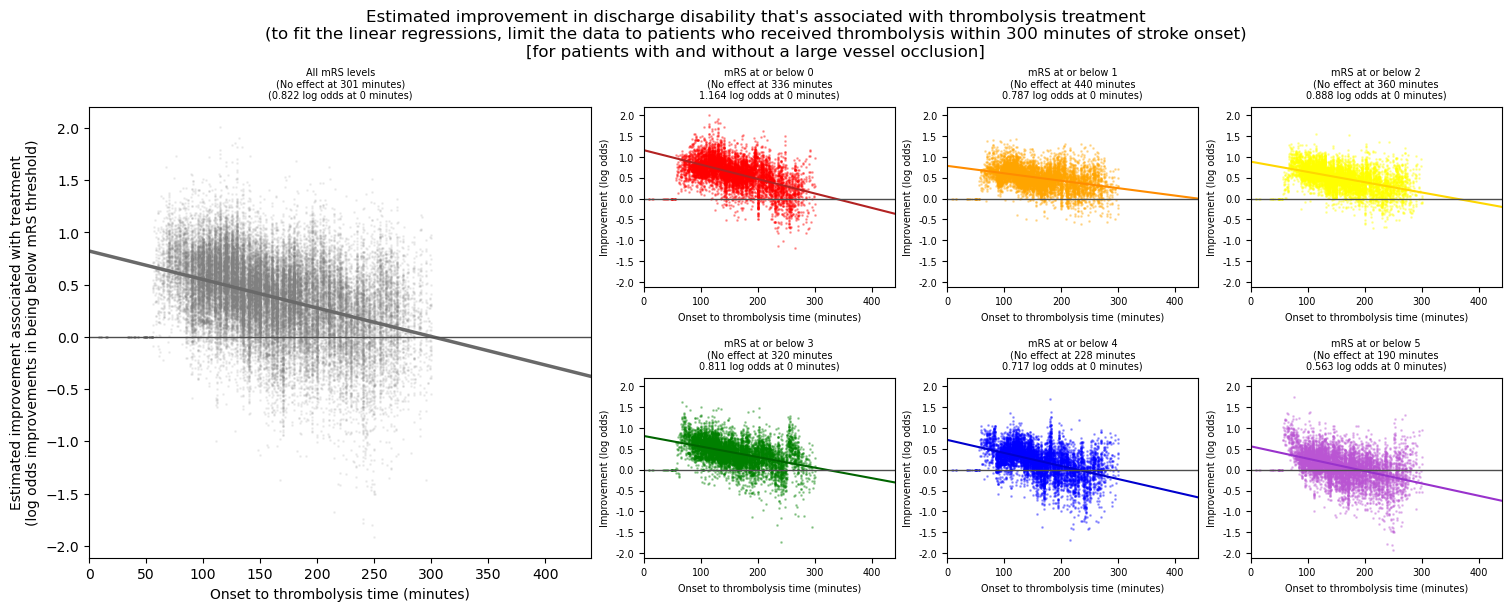

In [60]:
mask_max_time = (df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"] <= 
                                                        max_treatment_time)

create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask_max_time], 
                   max_treatment_time, "_nLVO_LVO", 
                   "[for patients with and without a large vessel occlusion]")

Repeat the plot for two subpopulations: LVO vs non-LVO (using <= NIHSS 10 and >= NIHSS 11 as a surrogate to identify an LVO)

For nLVO patients

Create mask for patients that recieved treatment within max treatment time, and are a non LVO

In [61]:
nonlvo_threshold = 10
mask_nlvo = df_test_ivt_and_no_ivt_shap["stroke_severity"] <= nonlvo_threshold

mask = mask_nlvo * mask_max_time

()

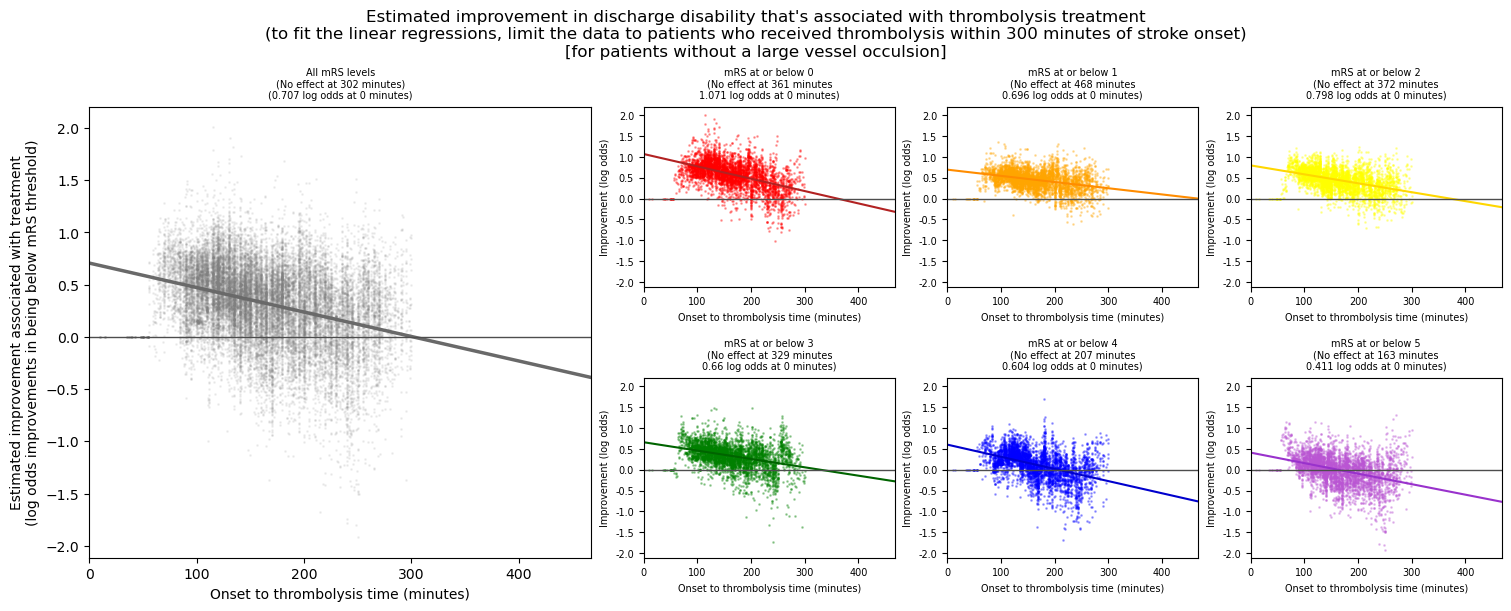

In [62]:
create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask], max_treatment_time, 
                   "_nLVO", "[for patients without a large vessel occulsion]")

For LVO patients

Create mask for patients that recieved treatment within max treatment time, and are an LVO

In [63]:
mask_lvo = df_test_ivt_and_no_ivt_shap["stroke_severity"] > nonlvo_threshold

mask = mask_lvo * mask_max_time

()

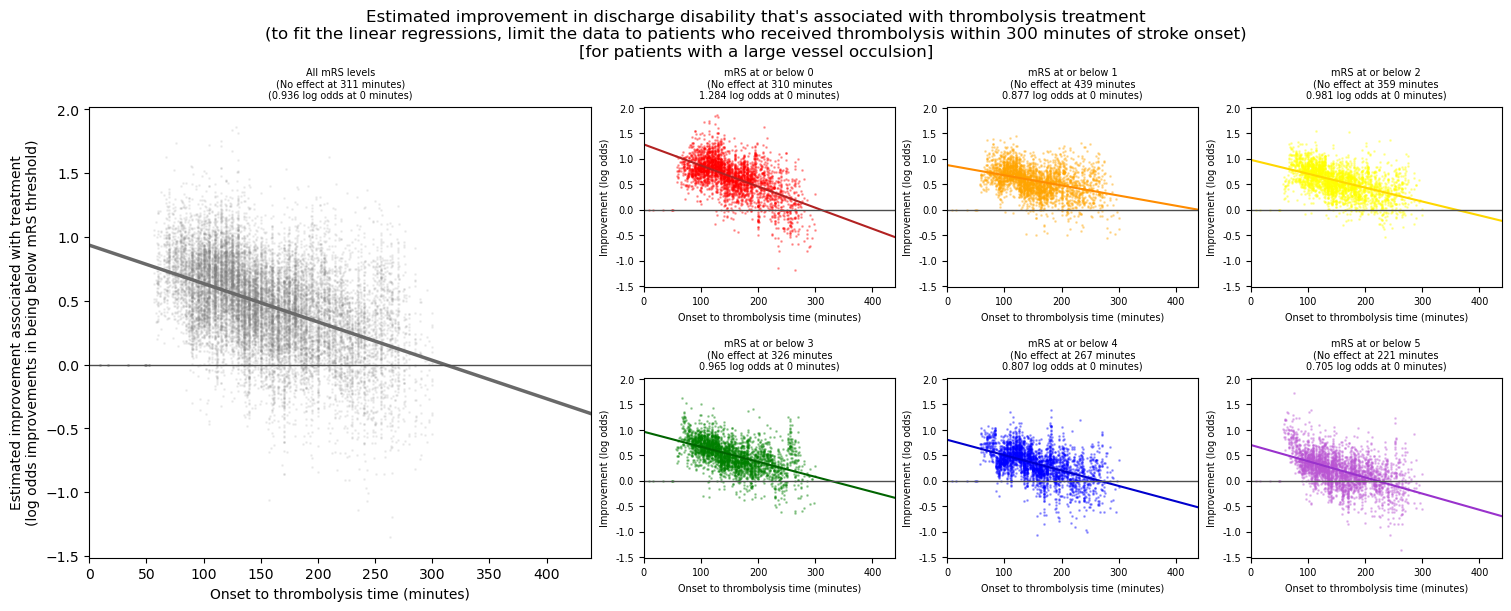

In [64]:
create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask], max_treatment_time, 
                   "_LVO", "[for patients with a large vessel occulsion]")

Save data for use in notebook 110 (that fits a model to predict the predicted improvement due to IVT)

In [65]:
filename = os.path.join(paths.data_save_path, (paths.notebook + 
                        paths.model_text + "_improvement_due_to_ivt.csv"))
df_test_ivt_and_no_ivt_shap.to_csv(filename)

Duration to run notebook

In [66]:
str(datetime.timedelta(seconds=(time.time()-start_time)))

'0:00:04.652651'